# Import Packages

In [1]:
# For Data Preparation
import tensorflow as tf
import numpy as np
import pandas as pd
import re # regular expressions


# To clean up texts
import nltk.data
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('punkt')
tokenizer = nltk.data.load('nltk:tokenizers/punkt/english.pickle')


# For Word Embedding
from collections import Counter
import gensim
import gensim.models as g
from gensim.models import Word2Vec
from gensim.models import Phrases

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt


# For the Model
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import LSTM, Bidirectional,Dropout, Input, SpatialDropout1D, CuDNNLSTM, Dense
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences


from mlxtend.plotting import plot_learning_curves
import matplotlib.pyplot as plt
from mlxtend.data import iris_data
from mlxtend.preprocessing import shuffle_arrays_unison

import logging

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/eunbeejang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/eunbeejang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Using TensorFlow backend.


# Data Preparation

In [2]:
# Data Processing


# Load the data from a CSV (returns type(dataframe))
bias_data = pd.read_csv('./scrapeBIG2.csv', sep=',',  encoding='latin-1') # encoding='latin-1', names=cols, header=None,
print("Data loaded.")

# Randomize data
bias_data = bias_data.reindex(np.random.permutation(bias_data.index))

# Replace NAN with Zero(0)
bias_data.fillna(0, inplace=True)

print("Size of the data: ", len(bias_data))

Data loaded.
Size of the data:  1614


In [3]:
# See how the data looks like

bias_data[:10]

,Sentence,Bias,Random,Sex,Age,Occupation,Citizenship
1440,Dealing with racism and sexism means that blac...,0,0.629908,0.0,0.0,0.0,0.0
985,Multi-generational holidays Multi-generational...,1,0.165127,0.0,0.0,0.0,0.0
745,Big up fibre It's your weight-loss pal.,1,0.697759,0.0,0.0,0.0,0.0
1142,"It's one thing to describe an ideal leader, it...",0,0.817630,0.0,0.0,0.0,0.0
1263,Cancel wine time and save a bucketload of empt...,1,0.456883,0.0,0.0,0.0,0.0
189,Only you can make this decision.,1,0.827420,0.0,0.0,0.0,0.0
531,That answers why do men need space after sex o...,0,0.709310,0.0,0.0,0.0,0.0
1171,"It is actually strength, hidden within softnes...",0,0.193134,0.0,0.0,0.0,0.0
1070,Look for one with cinnamon or the herb gymnema...,1,0.996571,0.0,0.0,0.0,0.0
1596,Where are my car keys?,1,0.045807,0.0,0.0,0.0,0.0


In [4]:
sentence = bias_data['Sentence']
label = bias_data['Bias']

print(type(sentence))
print(type(label))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [5]:
# Access each sentence
print(sentence[0])

If you had a man's genitals you were assigned to a men's prison.


In [6]:
# Convert a sentence into a list of words

def sentence_to_wordlist(sentence, remove_stopwords=False):
    # 1. Remove non-letters
    sentence_text = re.sub(r'[^\w\s]','', sentence)
    # 2. Remove all numbers
    sentence_text = re.sub(r'[0-9]+', '', sentence_text)
    # 3. Convert words to lower case and split them
    words = sentence_text.lower().split()
    # 4. Stemming
    words = [stemmer.stem(w) for w in words] 
    # 5. Lemmatizing
    words = [lemmatizer.lemmatize(word) for word in words]
    # 6. Return a list of words
    return(words)

In [7]:
sentence_to_wordlist(sentence[0])

['if',
 'you',
 'had',
 'a',
 'man',
 'genit',
 'you',
 'were',
 'assign',
 'to',
 'a',
 'men',
 'prison']

In [8]:
# whole data into a list of sentences where each sentence is a list of word items
def list_of_sentences(data):
    sentences = []
    for i in data:
        sentences.append(sentence_to_wordlist(i))
    return sentences

In [9]:
sentences = list_of_sentences(bias_data['Sentence'])
labels = bias_data['Bias'].tolist()

# Word Embedding

In [10]:
# Create Word Vectors

wv_model = Word2Vec(sentences, size=100, window=5, min_count=1, workers=16, sg=0, negative=5)
word_vectors = wv_model.wv
words = list(wv_model.wv.vocab)

# Calling init_sims will make the model will be better for memory
# if we don't want to train the model over and over again
wv_model.init_sims(replace=True)

#n_words = print(len(words))

print("Number of word vectors: {}".format(len(word_vectors.vocab)))

# save model
wv_model.save('model.bin')

# load model
new_model = Word2Vec.load('model.bin')



Number of word vectors: 3863


/Users/eunbeejang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


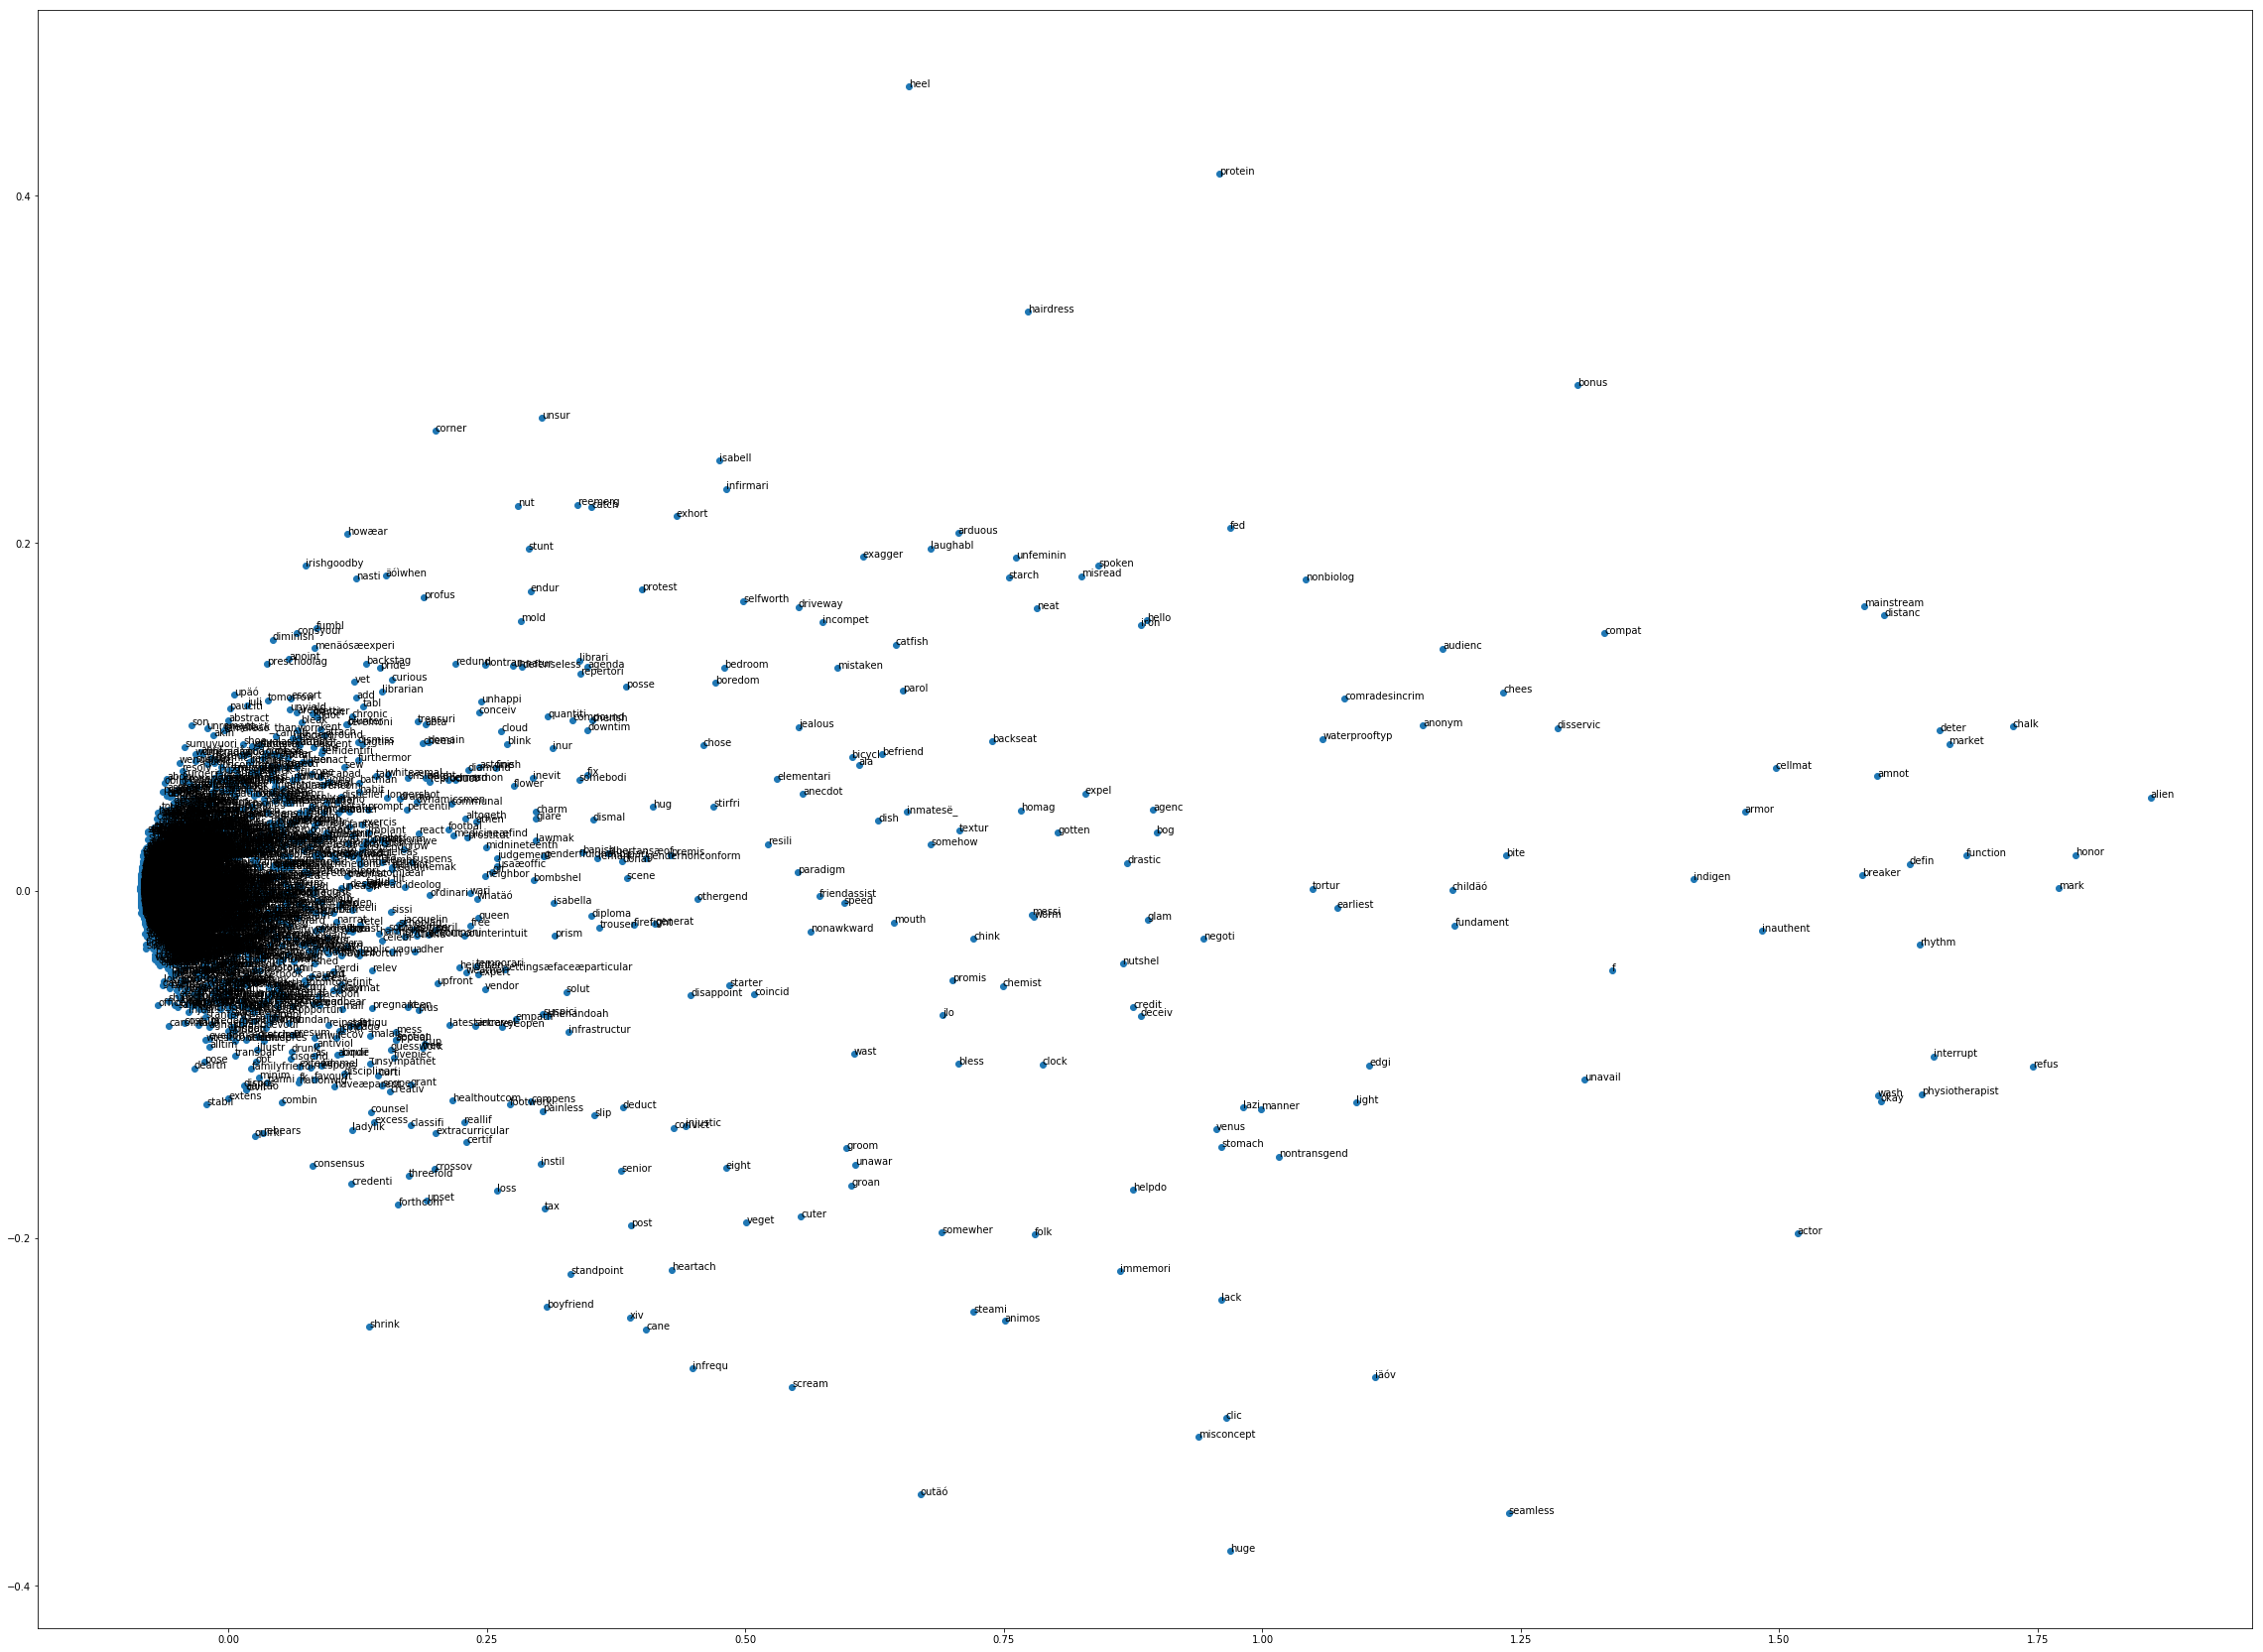

In [11]:

# Fit a 2d PCA model to the vectors
X = wv_model[wv_model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# Create a scatter plot of the projection
plt.figure(figsize=(40,30))
plt.scatter(result[:, 0], result[:, 1])
words = list(wv_model.wv.vocab)

for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
    
plt.show()


In [12]:
# Visualize word2vec with t-SNE

# Deal with font errors
mpl.rcParams['axes.unicode_minus'] = False

# Vector only plot 50 words
X = wv_model[words]
tsne = TSNE(n_components = 2)
X_tsne = tsne.fit_transform(X[:50,:])
df = pd.DataFrame(X_tsne, index=words[:50], columns=['x','y'])
df.head(50)

/Users/eunbeejang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


,x,y
deal,36.912167,-78.677101
with,-30.982611,43.933723
racism,71.798981,-98.857536
and,22.061680,46.422256
sexism,-36.571865,159.918442
mean,57.117550,-2.030919
that,-21.471935,74.035927
black,8.732961,75.314835
woman,14.830493,-46.652275
in,-3.987956,49.547215


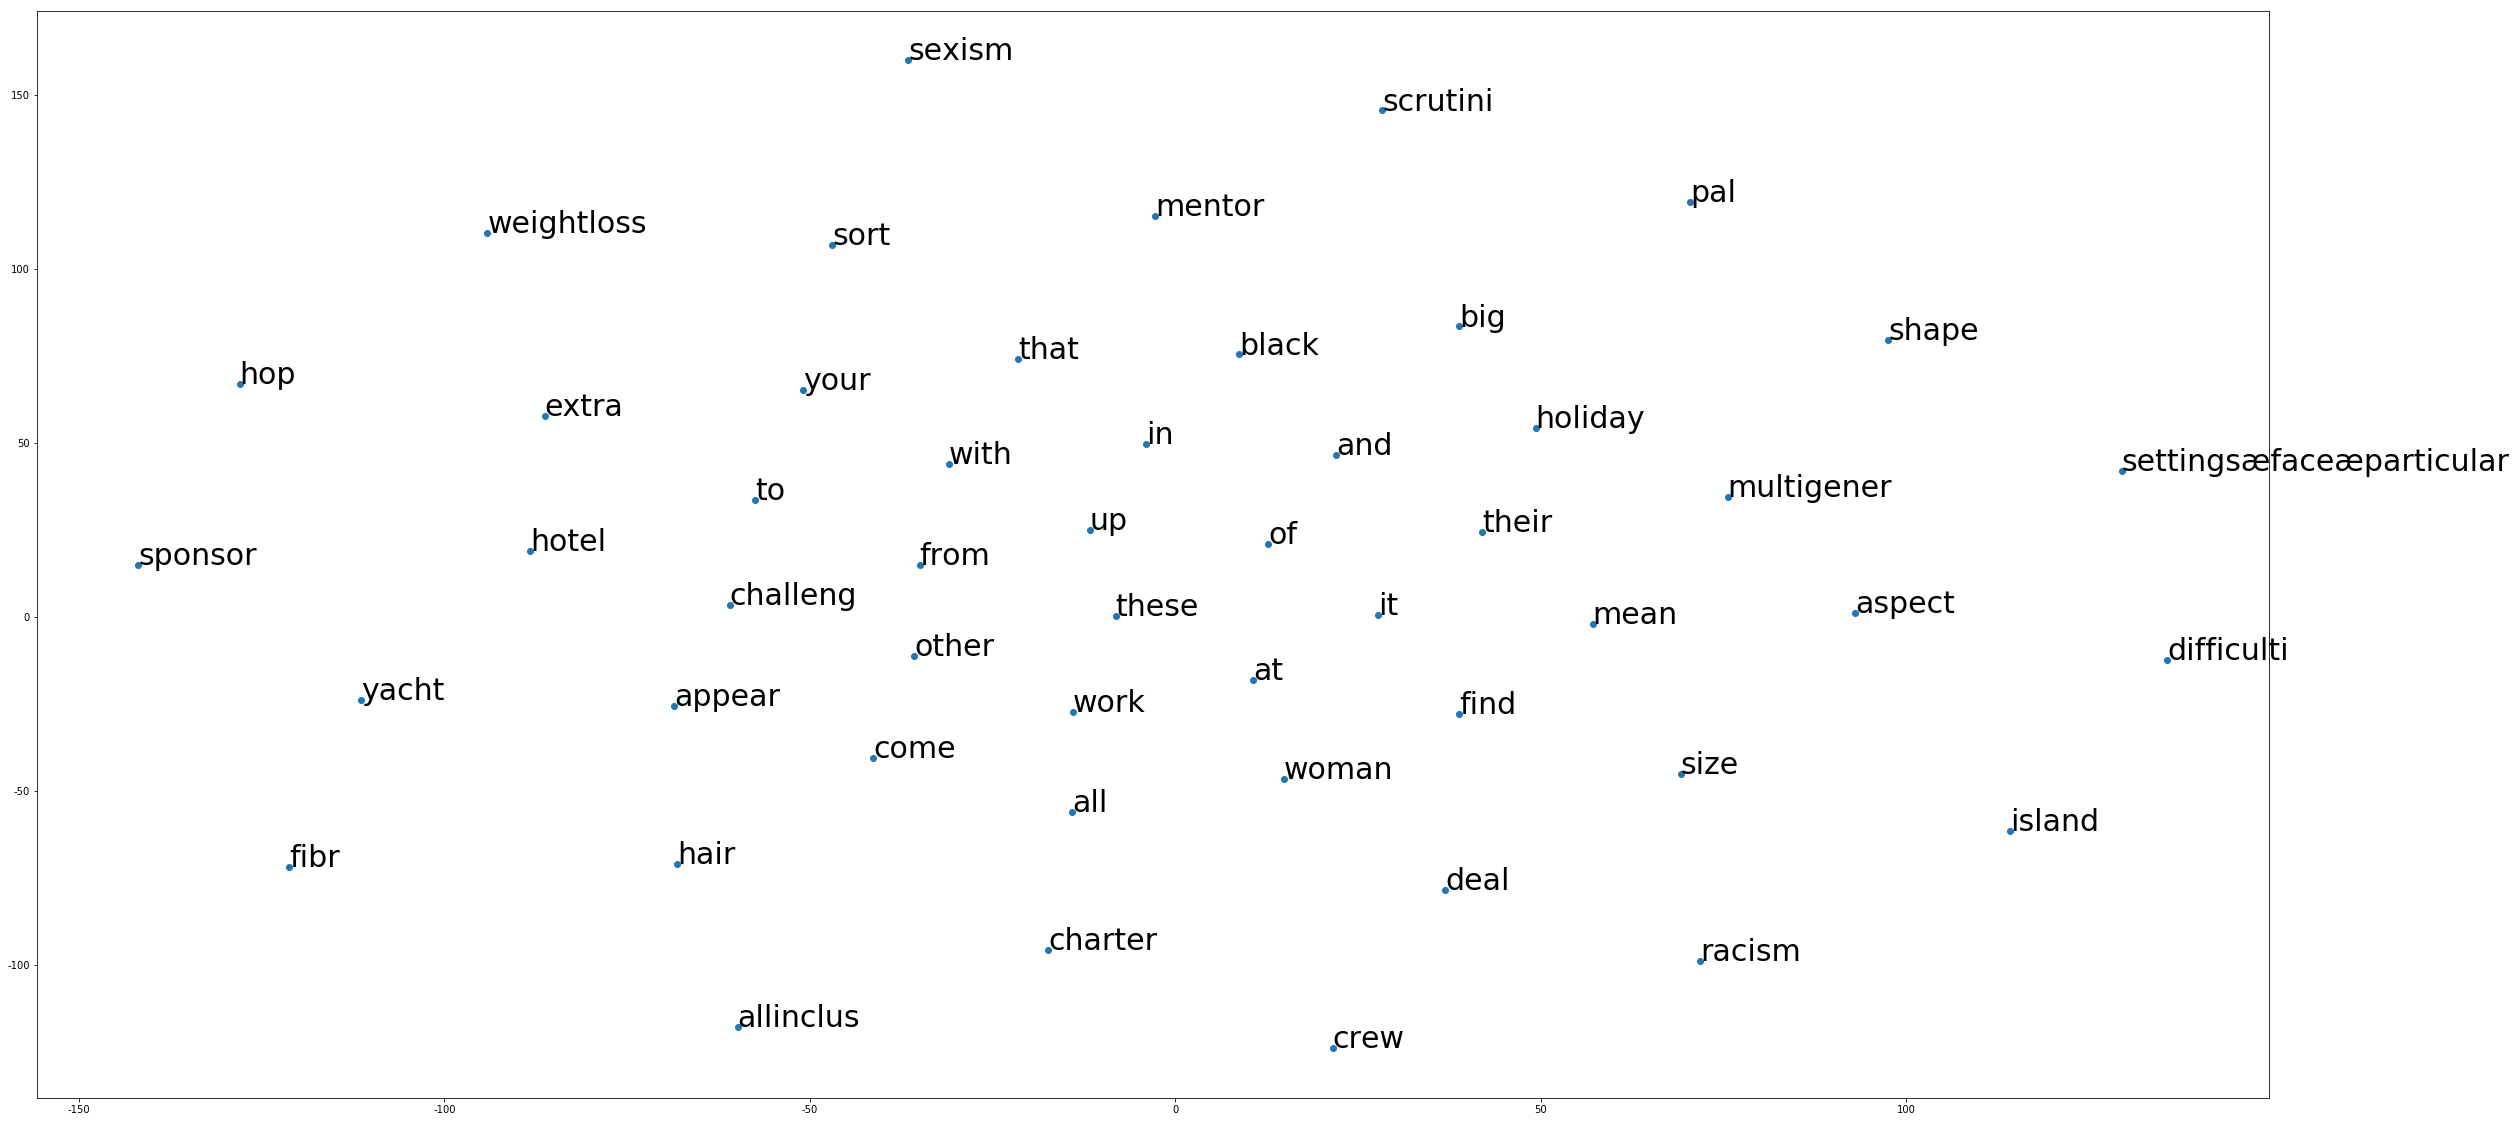

In [13]:
# Plot using TSNE
fig = plt.figure()
fig.set_size_inches(40,20)
ax = fig.add_subplot(1,1,1)
ax.scatter(df['x'], df['y'])
for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=30)
plt.show()

In [14]:
# Check similar words
wv_model.wv.most_similar("leadership")

[('tri', 0.9985891580581665),
 ('who', 0.9985276460647583),
 ('peopl', 0.9985193014144897),
 ('holiday', 0.9985122680664062),
 ('come', 0.9985055923461914),
 ('ballet', 0.9985044002532959),
 ('ha', 0.9985044002532959),
 ('negat', 0.9985026717185974),
 ('includ', 0.9984989762306213),
 ('into', 0.9984966516494751)]

In [15]:
# Build dictionary & inv_vocab

def create_vocab(data_collect, max_vocab):
    # Get raw data
    x_list = data_collect
    sample_count = sum([len(x) for x in x_list])
    words = []
    for data in x_list:
        words.extend([data])
    count = Counter(words) # word count
    inv_vocab = [x[0] for x in count.most_common(max_vocab)]
    vocab = {x: i for i, x in enumerate(inv_vocab, 1)}
    return vocab, inv_vocab

In [16]:
vocab, inv_vocab = create_vocab(words, len(words))
print(vocab)

{'deal': 1, 'with': 2, 'racism': 3, 'and': 4, 'sexism': 5, 'mean': 6, 'that': 7, 'black': 8, 'woman': 9, 'in': 10, 'these': 11, 'settingsæfaceæparticular': 12, 'challeng': 13, 'at': 14, 'work': 15, 'from': 16, 'difficulti': 17, 'find': 18, 'mentor': 19, 'sponsor': 20, 'to': 21, 'extra': 22, 'scrutini': 23, 'of': 24, 'their': 25, 'hair': 26, 'other': 27, 'aspect': 28, 'appear': 29, 'multigener': 30, 'holiday': 31, 'come': 32, 'all': 33, 'sort': 34, 'shape': 35, 'size': 36, 'allinclus': 37, 'hotel': 38, 'crew': 39, 'yacht': 40, 'charter': 41, 'island': 42, 'hop': 43, 'big': 44, 'up': 45, 'fibr': 46, 'it': 47, 'your': 48, 'weightloss': 49, 'pal': 50, 'one': 51, 'thing': 52, 'describ': 53, 'an': 54, 'ideal': 55, 'leader': 56, 'anoth': 57, 'a': 58, 'real': 59, 'person': 60, 'perform': 61, 'without': 62, 'be': 63, 'influenc': 64, 'by': 65, 'stereotyp': 66, 'about': 67, 'gender': 68, 'or': 69, 'what': 70, 'should': 71, 'cancel': 72, 'wine': 73, 'time': 74, 'save': 75, 'bucketload': 76, 'empti

In [17]:
# Find the index for the word
inv_vocab.index('imagin')

1044

In [18]:
# Find the max length sentence
def find_max_length_sentence(sentence):
    max_length = 0
    for i in sentence:
        length = len(sentence_to_wordlist(i))
        if max_length < length:
            max_length = length
    return max_length

In [19]:
seq_length = find_max_length_sentence(sentence)
print(seq_length)

75


In [20]:
# Map each word to corresponding vector
def map_to_vec(word):
    vec = wv_model[word]
    return vec

#map_to_vec('care')

In [21]:
# Embedding Matrix
def make_emb_matrix(inv_vocab):
    emb_matrix = []
    for word in inv_vocab:
        emb_matrix.append(map_to_vec(word))
    return emb_matrix

In [22]:
embedding = np.asarray(make_emb_matrix(inv_vocab))
#print(embedding)

/Users/eunbeejang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
"""
## Batch of integers (matrix of sentences where each word is represented as int)
#emb_matrix = np.zeros(shape = (len(words),100))


def integerize_sentences(sentences):
    int_sentences = np.zeros(shape = (len(sentences),seq_length), dtype=np.int16)
    i = 0
    for sentence in sentences:
        int_sentence = np.empty((1,0))
        for word in sentence:
            int_sentence = np.append(int_sentence, inv_vocab.index(word))
        int_sentences[i][0:len(sentence)] = int_sentence
        i += 1
    return int_sentences

sentence_matrix = integerize_sentences(sentences)

print(sentence_matrix[1500])

print(type(sentence_matrix))
sentence_matrix.shape

# Convert numpy array to list
#sentence_matrix = sentence_matrix.tolist()
#print(type(sentence_matrix))
#sentence_matrix[1500]
"""

'\n## Batch of integers (matrix of sentences where each word is represented as int)\n#emb_matrix = np.zeros(shape = (len(words),100))\n\n\ndef integerize_sentences(sentences):\n    int_sentences = np.zeros(shape = (len(sentences),seq_length), dtype=np.int16)\n    i = 0\n    for sentence in sentences:\n        int_sentence = np.empty((1,0))\n        for word in sentence:\n            int_sentence = np.append(int_sentence, inv_vocab.index(word))\n        int_sentences[i][0:len(sentence)] = int_sentence\n        i += 1\n    return int_sentences\n\nsentence_matrix = integerize_sentences(sentences)\n\nprint(sentence_matrix[1500])\n\nprint(type(sentence_matrix))\nsentence_matrix.shape\n\n# Convert numpy array to list\n#sentence_matrix = sentence_matrix.tolist()\n#print(type(sentence_matrix))\n#sentence_matrix[1500]\n'

# Training, Validation, Test dataset

In [24]:
# Creating the training and validation sets
X_train, X_test, Y_train, Y_test = train_test_split(sentences, labels,
                                                    test_size = 0.2,
                                                    random_state = 2,
                                                    shuffle= True)

# Initialize Word Embeddings in Keras

In [25]:
wv_dim = 100
num_words = len(word_vectors.vocab)
vocab = Counter(words)

In [26]:

word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(num_words-1))}

train_sequences = [[word_index.get(t, 0) for t in sentence]
             for sentence in X_train[:len(X_train)]]

test_sequences = [[word_index.get(t, 0)
                   for t in sentence] for sentence in X_test[:len(X_test)]]

# Pad zeros to match the size of matrix
train_data = pad_sequences(train_sequences, maxlen=seq_length, padding="post", truncating="post")
test_data = pad_sequences(test_sequences, maxlen=seq_length, padding="post", truncating="post")


In [28]:
# Initialize the matrix with random numbers
wv_matrix = (np.random.rand(num_words, wv_dim) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= num_words:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass


# LSTM Model

In [30]:
# Embedding
wv_layer = Embedding(num_words,
                     wv_dim,
                     mask_zero=False,
                     weights=[wv_matrix],
                     input_length=seq_length,
                     trainable=False)

# Inputs
comment_input = Input(shape=(seq_length,), dtype='int64')
embedded_sequences = wv_layer(comment_input)

# LSTM
embedded_sequences = SpatialDropout1D(0.2)(embedded_sequences)
x = Bidirectional(LSTM(64, return_sequences=False))(embedded_sequences)

# Output
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
preds = Dense(1, activation='sigmoid')(x)

# build the model
model = Model(inputs=[comment_input], outputs=preds)
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001, clipnorm=.25, beta_1=0.7, beta_2=0.99),
              metrics=['accuracy'])

print(model.summary())

hist = model.fit(train_data, Y_train, validation_data=(test_data, Y_test), epochs=15, batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 75, 100)           386300    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 75, 100)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total para

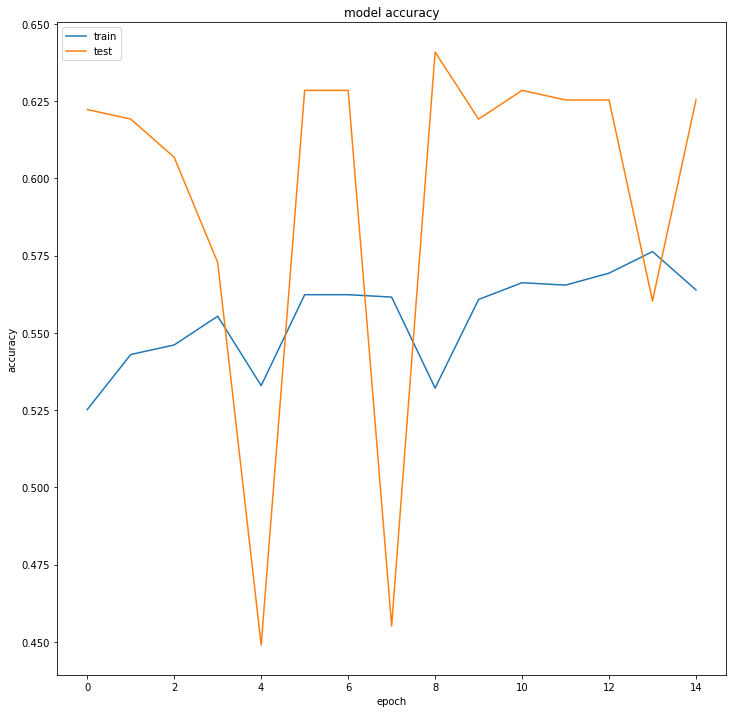

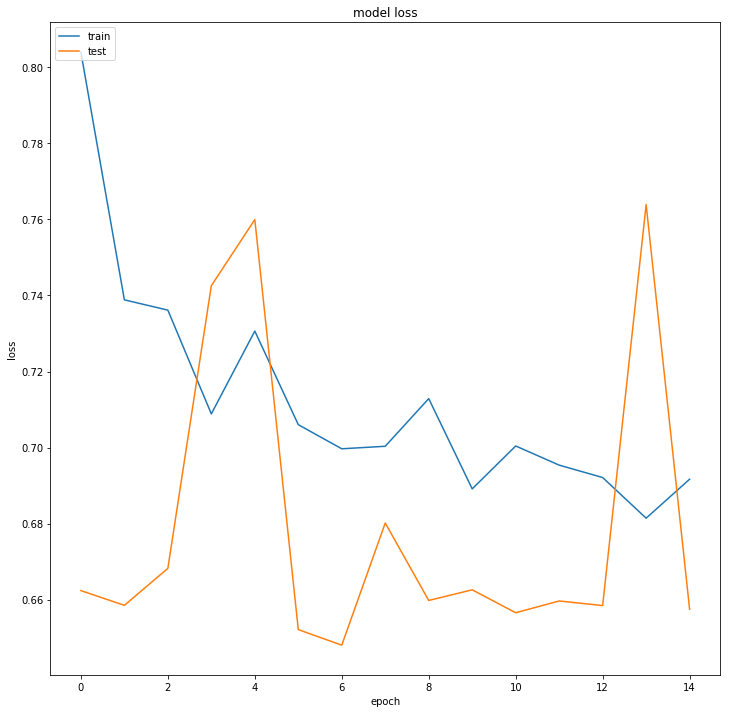

In [31]:
#print(hist.history.keys())
    
# summarize history for accuracy  
#plt.subplot(211)
plt.figure(figsize=(12,12))
plt.plot(hist.history['acc'])  
plt.plot(hist.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()
   
# summarize history for loss  
#plt.subplot(212)  
plt.figure(figsize=(12,12))
plt.plot(hist.history['loss'])  
plt.plot(hist.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

In [32]:
# Final evaluation of the model
scores, acc = model.evaluate(test_data, Y_test, verbose=2, batch_size =32)
print("LSTM Score: %.2f%%" % (scores*100)) # Evaluation of the loss function for a given input
print("LSTM Accuracy: %.2f%%" % (acc*100))

LSTM Score: 65.74%
LSTM Accuracy: 62.54%


# Predict Sentences (Still working on this)

In [ ]:
pred_text = sentence_to_wordlist("this is just some random text")
print(type(pred_text))

def pred_text_to_list(sentence):
    pred = []
    for word in sentence:
        if word in inv_vocab:
            pred.append(inv_vocab.index(word))
        else:
            pred.append(0)
    return pred

#print(pred_text.shape)

def integerize_single_sentence(sentence):
    pred_text = np.zeros(shape = (1, seq_length), dtype=np.int16)
    pred_text[0:] = np.asarray([pred_text_to_list(sentence)])
    return pred_text


testing = integerize_single_sentence(pred_text)
print(testing.shape)

def integerize_single(sentences):
    int_sentences = np.zeros(shape = (len(sentences),seq_length), dtype=np.int16)
    i = 0
    for sentence in sentences:
        int_sentence = np.empty((1,0))
        for word in sentence:
            int_sentence = np.append(int_sentence, inv_vocab.index(word))
        int_sentences[i][0:len(sentence)] = int_sentence
        i += 1
    return int_sentences


In [ ]:
import keras.preprocessing.text


prediction = model.predict(testing)
print(prediction)

In [ ]:
for layer in model.layers:
    weights = layer.get_weights()
    print(np.array(weights).shape)

# Logistic Regression Model

In [33]:

def sentence_to_emb(sentence):
    emb = 0
    for word in sentence:
        emb += map_to_vec(word)
    return emb

sentence_to_emb(sentences[0])


def all_to_emb(sentences):
    data = []
    for each_sentence in sentences:
        data.append(sentence_to_emb(each_sentence))
    return data
    
log_data = all_to_emb(sentences)
log_data[:5]

log_data = np.asarray(log_data)
log_data.shape

/Users/eunbeejang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


(1614, 100)

In [34]:
X_train_log, X_test_log, Y_train_log, Y_test_log = train_test_split(log_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    random_state = 2,
                                                                    shuffle= True)
print(X_train_log.shape)
print(X_test_log.shape)

(1291, 100)
(323, 100)


In [35]:
# Logistic Regression
classifier = LogisticRegression(solver="lbfgs", max_iter=100)
classifier.fit(X_train_log, Y_train_log)
log_train_score = classifier.score(X_train_log, Y_train_log) # score = mean accuracy
#log_test_score = classifier.score(X_test_log, Y_test_log)
print("Logistic Train Score: %.2f%%" % (log_train_score*100))

Logistic Train Score: 61.50%


In [36]:
print(classifier.predict(X_train_log[:50])- Y_train_log[:50])

[ 0  0  0  1  0  0 -1  0  0 -1 -1  1 -1  0 -1 -1 -1  0 -1  0  0  0  0  0 -1
  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0 -1  1 -1 -1  0  0  0  0  0  0]


In [37]:
print(np.mean(Y_train_log))

0.444616576297
